 # Animation Dynamique (Cartographie sur le Web)

# Excercice 02 

In [15]:
from pyproj import CRS
import osmnx as ox                  
import networkx as nx               
import matplotlib.pyplot as plt      
import geopandas as gpd              
import folium    
from folium import plugins
import os

In [2]:
# Localisation d'une commune de la plaine commune  : 

# Ville Choisie : Saint-Denis
town = {'city':'saint denis','state':'Seine-Saint-Denis','country' : 'France'}

In [3]:
#Geocoder pour récuperer le Dataframe de la ville et récupérer le polygon de Saint-denos
saint_denis = ox.geocode_to_gdf(town)

<AxesSubplot:>

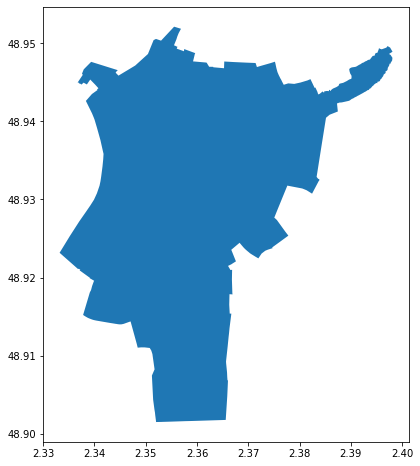

In [4]:
#Affichage du polygon
saint_denis.plot(figsize=(8,8))

In [5]:
tag = {'amenity': ['townhall','school','music_school','university','hospital','community_centre', 'social_centre', \
                  'courthouse','police', 'fire_station','post_office','theatre','public_bookcase'],
                  'leisure':['sports_centre']}
    

In [6]:
#Récupération des batiments public dans une variable :
batiments = ox.geometries_from_place(town, tag)

In [7]:
# Récupération des bâtiments ayant une géométrie de type 'Polygon'
polygone = batiments.loc[batiments.geometry.geometry.type=='Polygon']
point = batiments.loc[batiments.geometry.geometry.type=='Point']

<AxesSubplot:>

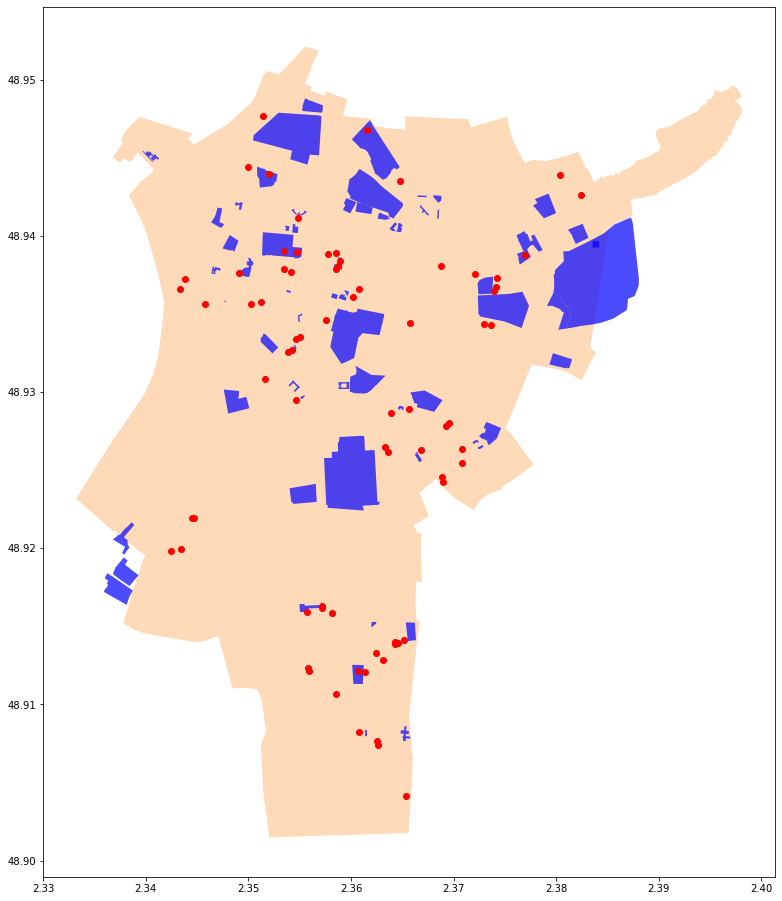

In [8]:
#Dessiner les données récupérées sur un Plot avec Matplotlib
fig, ax = plt.subplots(figsize=(20,16))
# notre aire d'intérêt
saint_denis.plot(ax=ax, facecolor='peachpuff')
# les batiments
polygone.plot(ax=ax, facecolor='blue', alpha=0.7)
point.plot(ax=ax, color = 'red')

In [9]:


basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True,
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True,
        show=False)}


In [16]:
title = 'Batiments public à saint-Denis'
title_html = '''
                 <h5 align="center" style="font-size:16px"><b>{}</b></h5>
                 '''.format(title)


fond_carte = r'https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png'


map_france = folium.Map(location=[48.92317, 2.33681],
                            zoom_start=13,
                            tiles=fond_carte, attr= "basemap.cartocdn", name='Fond de Carte')

#sait denis 
folium.GeoJson(saint_denis ,
               name="Limites administratives de Saint-Denis",
               overlay=True,
               control=True,
               style_function=lambda feature: {
               'fillColor': 'dark',
               'color': '#600622',
               'weight': 3,
               'dashArray': '3',
               }).add_to(map_france)

#Batiments
folium.GeoJson(polygone,
            name="Bâtiments publics de Saint-Denis(Points)",
            marker = folium.CircleMarker(color='green',radius=5),
            overlay=True,
            control=True,
            ).add_to(map_france)




#Ajout les autres widgets 
folium.LayerControl(position='bottomright').add_to(map_france)
#widget mesurement 
Mesure=folium.plugins.MeasureControl(
    position='bottomright',
    primary_length_unit='meters',
    secondary_length_unit='miles',
    primary_area_unit='sqmeters',
    secondary_area_unit='acres').add_to(map_france)


folium.plugins.Draw(export=True,
            position='bottomleft',
            filename='mon_dessin.geojson',
            draw_options={'polyline': {'allowIntersection': False}},
            edit_options={'poly': {'allowIntersection': False}}
            ).add_to(map_france)

map_france.get_root().html.add_child(folium.Element(title_html))
map_france.save("./maps/bati_saintDenis.html")

Calcule de l'itinéraire en utilisant le réseau routier de la ville de saint denis 

In [24]:
# Récupération des informations du résau routier de Saint-Denis
graphe= ox.graph_from_place(town, network_type = 'drive')

In [25]:
graphe

In [26]:
nodes, edges = ox.graph_to_gdfs(graphe)

In [27]:
routes=edges

In [29]:
Polygon = batiments.loc[batiments.geometry.geometry.type=='Polygon']

Point = batiments.loc[batiments.geometry.geometry.type=='Point']



<AxesSubplot:>

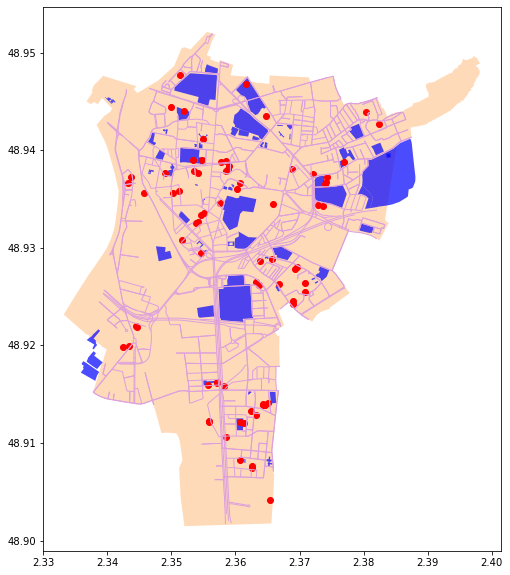

In [31]:
#Graphique du réseau routier récupéré : 
fig, ax = plt.subplots(figsize=(20,10))
# notre aire d'intérêt
saint_denis.plot(ax=ax, facecolor='peachpuff')
# les arêtes du réseau routier
routes.plot(ax=ax, linewidth=1, edgecolor='plum')
# les batiments
Polygon.plot(ax=ax, facecolor='blue', alpha=0.7)
#batiments en points
Point.plot(ax=ax, facecolor='red')

In [33]:
mairie = batiments[batiments['name'].isin(["Mairie de Saint-Denis"])] 

In [34]:
# un filtre pour obtenir les données des centres de loisirs à saint_denis 
loisirs = batiments[batiments['leisure'].isin(["sports_centre"])] 

In [35]:
# un filtre pour obtenir les données du Gymnase choisi
gymnase_SD = batiments[batiments['name'].isin(["Gymnase Irène Popard"])] 

In [36]:
graph_projete = ox.project_graph(graphe)

In [37]:
#Récupérer les nodes et edges dans un geodataframe 
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_projete, nodes=True, edges=True)

In [38]:
CRS(edges_proj.crs).to_epsg()

32631

In [39]:
# Il faut reprojeter la mairie et le gymnase sur la projection des edges
projection = CRS.from_epsg(32631)
mairie= mairie.to_crs(projection)
gymnase_SD_proj = gymnase_SD.to_crs(projection)

In [40]:
convex_hull = mairie.unary_union.convex_hull


In [41]:
# Calculer le centroide de l'enveloppe convexe ( Du polygone de la mairie de Saint-Denis)
centroide = (convex_hull.centroid)


In [42]:
# On récupère les coordonnées x et y de l'origine de Point de départ (La mairie) dans un tuple 
orig_xy = (centroide.y, centroide.x)

In [43]:
#Récupérer la valeur du points de destination(Gymnase) dans un tuple 
target = gymnase_SD_proj.geometry.values[0]

In [44]:
#Récupérer les coordonnées x,y de la destination (Le Gymnase)
target_xy=(target.x, target.y)

In [45]:
# on récupère le noeud de départ pour la mairie
orig_node = ox.distance.get_nearest_node(graph_projete, orig_xy, method='euclidean')

/home/nsam/anaconda3/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [46]:
#On récupère le noeud de destination pour le Gymnase :
dest_node = ox.distance.nearest_nodes(graph_projete, target.x, target.y, return_dist=False)

In [47]:
# Récupérer la ligne du geodataframe des nodes_projeté du sommet le plus près de l'origine
orig_closest = nodes_proj.loc[orig_node]

In [48]:
# Récupérer la ligne du geodataframe des nodes_projeté du sommet le plus près de la destination
dest_closest = nodes_proj.loc[dest_node]

In [49]:
#Stocker les valeurs retournées pour les noeuds des sommets dans geodataframe 
od_nodes = gpd.GeoDataFrame([orig_closest, dest_closest], geometry='geometry', crs=nodes_proj.crs)

In [50]:
# Calcul du chemin le plus proche : 
chemin_proche = nx.shortest_path(G=graph_projete, source=orig_node, target=dest_node, weight='length')

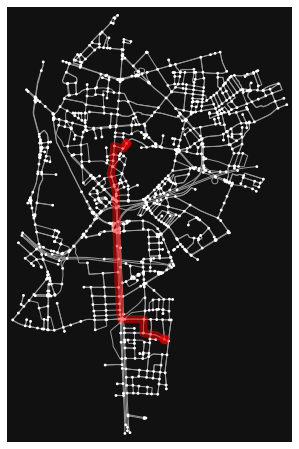

In [51]:
fig, ax = ox.plot_graph_route(graph_projete, chemin_proche,route_linewidth=8, node_size=8)

In [52]:
# Récupérer les sommets du chemin le plus proche 
chemin= nodes_proj.loc[chemin_proche] 


In [53]:
# On peut donc créer une LineString avec Shapely
from shapely.geometry import LineString, Point

route= LineString(list(chemin.geometry.values))

In [54]:
# création de la geodataframe
route_geometrie = gpd.GeoDataFrame([[route]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])


In [55]:
#Sauvegarder la geodataframe pour la reutiliser dans la cartogrpahie 
route_geometrie.to_file("data/cheminPlusProche.geojson")

# Cartographie du chemin le plus proche 

In [56]:
title = 'Batiments public à saint-Denis'
title_html = '''
                 <h5 align="center" style="font-size:16px"><b>{}</b></h5>
                 '''.format(title)


fond_carte = r'https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png'


map_france = folium.Map(location=[48.92317, 2.33681],
                            zoom_start=13,
                            tiles=fond_carte, attr= "basemap.cartocdn", name='Fond de Carte')

#sait denis 
folium.GeoJson(saint_denis ,
               name="Limites administratives de Saint-Denis",
               overlay=True,
               control=True,
               style_function=lambda feature: {
               'fillColor': 'dark',
               'color': '#600622',
               'weight': 3,
               'dashArray': '3',
               }).add_to(map_france)

#Batiments
folium.GeoJson(polygone,
            name="Bâtiments publics de Saint-Denis(Points)",
            ).add_to(map_france)
folium.GeoJson(route_geometrie,
               style_function=lambda feature: {
               'fillColor': 'dark',
               'color': 'green',
               'weight': 3,
               'dashArray': '3',
               }
            ).add_to(map_france)




#Ajout les autres widgets 
folium.LayerControl(position='bottomright').add_to(map_france)
#widget mesurement 
Mesure=folium.plugins.MeasureControl(
    position='bottomright',
    primary_length_unit='meters',
    secondary_length_unit='miles',
    primary_area_unit='sqmeters',
    secondary_area_unit='acres').add_to(map_france)


folium.plugins.Draw(export=True,
            position='bottomleft',
            filename='mon_dessin.geojson',
            draw_options={'polyline': {'allowIntersection': False}},
            edit_options={'poly': {'allowIntersection': False}}
            ).add_to(map_france)

map_france.get_root().html.add_child(folium.Element(title_html))
map_france
map_france.save("./maps/CheminPlusProche.html")

<h1>Partie quatre<h1> 
    
    Cartographie des différentes données

In [57]:
#Routes
routes1 = ox.geometries_from_place(town, tags={'highway':True})
routes  = routes1.loc[routes1.geometry.geometry.type!='Point']

#Eau
eau1 = ox.geometries_from_place(town, tags={'waterway':True})
eau = eau1.loc[eau1.geometry.geometry.type!='Point']

#Electrique
elec1 = ox.geometries_from_place(town, tags={'power':True})
elec = elec1.loc[elec1.geometry.geometry.type!='Point']

In [58]:
title = 'Carte de réseau routier, eau et electricité à Saint-Denis.'
title_html = '''<h5 align="center" style="font-size:16px"><b>{}</b></h5>'''.format(title)


fond_carte = r'https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png'


map_france = folium.Map(location=[48.92317, 2.33681],
                            zoom_start=13,
                            tiles=fond_carte, attr= "basemap.cartocdn", name='Fond de Carte')

#sait denis 
folium.GeoJson(saint_denis ,
               name="Limites administratives de Saint-Denis",
               overlay=True,
               control=True,
               style_function=lambda feature: {
               'fillColor': 'dark',
               'color': '#600622',
               'weight': 5,
               'dashArray': '3',
               }).add_to(map_france)

#Batiments
folium.GeoJson(polygone,
            name="Bâtiments publics de Saint-Denis",
            ).add_to(map_france)

folium.GeoJson(route_geometrie,
               style_function=lambda feature: {
               'fillColor': 'dark',
               'color': 'green',
               'weight': 3,
               'dashArray': '3',
               }
            ).add_to(map_france)


folium.GeoJson(routes,
            name="Routes de Saint-Denis",
            style_function=lambda feature: {
            'fillColor': 'dark',
            'color': 'white',
            'weight': 0.5,
            'dashArray': '3',
        }   
            ).add_to(map_france)

folium.GeoJson(elec,
            name="Electricite de Saint-Denis",
            style_function=lambda feature: {
            'fillColor': 'dark',
            'color': 'yellow',
            'weight': 3,
            'dashArray': '3',
        }  
            ).add_to(map_france)

folium.GeoJson(eau,
            name="Eau de Saint-Denis",
            ).add_to(map_france)

#Ajout les autres widgets 
folium.LayerControl(position='bottomright').add_to(map_france)
#widget mesurement 
Mesure=folium.plugins.MeasureControl(
    position='bottomright',
    primary_length_unit='meters',
    secondary_length_unit='miles',
    primary_area_unit='sqmeters',
    secondary_area_unit='acres').add_to(map_france)


folium.plugins.Draw(export=True,
            position='bottomleft',
            filename='mon_dessin.geojson',
            draw_options={'polyline': {'allowIntersection': False}},
            edit_options={'poly': {'allowIntersection': False}}
            ).add_to(map_france)

map_france.get_root().html.add_child(folium.Element(title_html))
map_france
map_france.save("./maps/ReseauSaintDenis.html")